## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.tree import plot_tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize#, sent_tokenize, RegexpTokenizer, wordpunct_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [2]:
# Define dataframe path
df_path = "../data/final_dataset.csv"

In [3]:
# load data
df = pd.read_csv(df_path).drop(columns="Unnamed: 0")

# Get some basic information 
print(f"Sample Data :{df.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df.shape[0]}")
print(f"\n--------------------------\n\n Total number of columns : {df.shape[1]}")

Sample Data :            author                                        description  \
0          TuaAnon  yes, it's an lte watch with data turned on, no...   
1  DemandScary1934  how accurate is the active/total calorie track...   
2         Vinumite  fell very hard blackout drunk and lost watch. ...   
3          Damarou  pls tell me i‘m not the only one who has such ...   
4       ThorNike13  deleted apps in watch app on iphone with weird...   

    subreddit  des_word_count  
0  AppleWatch              48  
1  AppleWatch              10  
2  AppleWatch              59  
3  AppleWatch              15  
4  AppleWatch              15  

--------------------------

 Columns : ['author', 'description', 'subreddit', 'des_word_count']

--------------------------

 Size of the dataset : 5270

--------------------------

 Total number of columns : 4


In [4]:
# Drop unusefull columns
df.drop(columns =["author", "des_word_count"], inplace=True)

In [5]:
# Create label column (target column)
df["subreddit"] = df["subreddit"].map({"GalaxyWatch": 1, "AppleWatch":0})

## Functions

In [6]:
# cite: Got help form Katie Sylvia
# a function for stemming
def stem_words(text):
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

In [7]:
# Grid search over with pipeline estimator
def gridsearching(estimator, param_grid, model_name, transformer_name):
    
    print(f" Summary of {model_name} Model with {transformer_name} Transformer Evaluation ".center(115, "="))
    
    # Instantiate a GridSearch model
    gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, n_jobs=5)

    # Fit the model to traning data
    gs.fit(X_train, y_train)

    # Get to know wich params were the best ones
    print(" The Best Params ".center(34, "="))
    print(gs.best_params_)
    print()

    # Get to know the best score
    print(" The Best Score ".center(34, "="))
    print(gs.best_score_)
    print()

    # Train data score
    print(" Train Score ".center(34, "="))
    print(gs.score(X_train, y_train))
    print()

    # Test data score
    print(" Test Score ".center(34, "="))
    print(gs.score(X_test, y_test))
    
    # Get predictions
    preds = gs.predict(X_test)

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap="Blues", values_format="d")

    plt.title(f"The Confusion Matrix of {model_name} with {transformer_name}");

    # Evaluate a model
    print(f" Evaluation Metrics ".center(34, "="))
    print(f"Accuracy  ---------- {accuracy_score(y_test, preds)}")
    print(f"Precision  --------- {precision_score(y_test, preds)}")
    print(f"Sensitivity  ------- {recall_score(y_test, preds)}")
    print(f"Specifity  --------- {tn/(tn + fp)}")

In [58]:
# cite: got that function from GA 603-lesson_random_forest (Katie Sylvia)
def plot_feature_importance(importance, names, model_type):


    # Create a DataFrame using a Dictionary
    df = pd.DataFrame({"feature_names":names,
                       "feature_importance":importance})

    # Sort the DataFrame in order decreasing feature importance
    df.sort_values(by=["feature_importance"], ascending=False,inplace=True)
    top_features = df.head(20)

    # Define size of bar plot
    plt.figure(figsize=(10,8))
    
    # Plot Searborn bar chart
    sns.barplot(x=top_features["feature_importance"], y=top_features["feature_names"])
    
    # Add chart labels
    plt.title(model_type +  "Feature Importance ")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")
    

## Modeling

In [9]:
# Define X (features) and y(target)
X = df["description"]
y = df["subreddit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f"X shape ---------- {X.shape}")
print(f"y shape ---------- {y.shape}")

X shape ---------- (5270,)
y shape ---------- (5270,)


### Baseline accuracy

In [10]:
# Get the ratio of classes
y_test.value_counts(normalize=True)

0    0.534143
1    0.465857
Name: subreddit, dtype: float64

**Baseline accuracy score is 0.53 which is the majority class**

## Decision Tree

### Decision Tree with CountVectorizer

In [18]:
# Instantiate DecisionTree
tree = DecisionTreeClassifier()

In [19]:
# Instantiate the pipeline with Bagged Decision Tree and CountVectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("bg", BaggingClassifier(tree))
])

In [20]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('bg', BaggingClassifier(base_estimator=DecisionTreeClassifier()))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'bg': BaggingClassifier(base_estimator=DecisionTreeClassifier()),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'bg__base_estimator__ccp_alpha': 0.0,
 'bg__base_estimator__class_weight': None,
 'bg__base_estimator__criterion': 'gini',
 'bg__base_estimator__max_depth': None,
 'bg__base_estimator__max_features': None,
 'bg__base_estimator__max_leaf_nodes': None,
 'bg__base_estimator__min_i

In [22]:
# Set pipeline params by cvec
pipe_params = {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "bg__base_estimator__max_depth": [None, 1, 2, 3, 4],
    "bg__n_estimators": [100]
}

==================== Summary of Decision Tree Model with CountVectorizer Transformer Evaluation ===================
======== The Best Params =========
{'bg__base_estimator__max_depth': None, 'bg__n_estimators': 100, 'cvec__max_df': 0.95, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'cvec__tokenizer': None}

========= The Best Score =========
0.8712006913216725

========== Train Score ===========
0.9989878542510121

=========== Test Score ===========
0.877845220030349


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.877845220030349
Precision  --------- 0.883248730964467
Sensitivity  ------- 0.8501628664495114
Specifity  --------- 0.9019886363636364


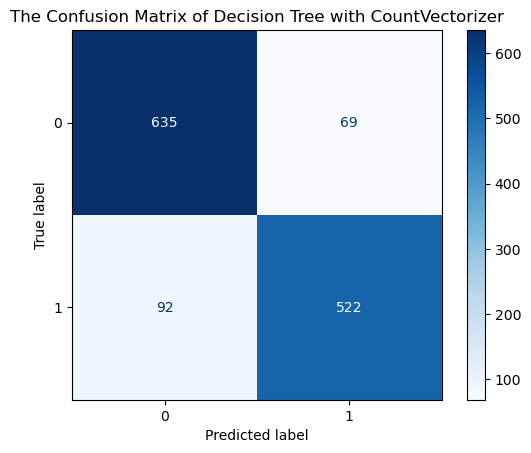

In [23]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="Decision Tree", transformer_name="CountVectorizer")

### Decision Tree with TfidVectorizer

In [24]:
# Instantiate Decision Tree
tree = DecisionTreeClassifier()

In [25]:
# Instantiate the pipeline with Bagged Decision Tree and TfidVectorizer transformer
pipe_tvec = Pipeline([
    ("tvec", TfidfVectorizer()),
    ("bg", BaggingClassifier(tree))
])

In [26]:
# Get pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('bg', BaggingClassifier(base_estimator=DecisionTreeClassifier()))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'bg': BaggingClassifier(base_estimator=DecisionTreeClassifier()),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'bg__base_estimator__ccp_alpha': 0.0,
 'bg__base_estimator__class_weight': None,
 'bg__base_estimator__criterion': 'gini',
 'bg__base_estimator__max_depth': None,
 'bg__base_

In [27]:
# Set pipeline params by cvec
pipe_tvec_params = {
    "tvec__tokenizer": [None, stem_words],
    "tvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "tvec__min_df": [2, 3],
    "tvec__max_df": [.9, .95],
    "tvec__stop_words": [None, "english"],
    "tvec__ngram_range": [(1, 1), (1, 2)],
    "bg__base_estimator__max_depth": [None, 1, 2, 3, 4],
    "bg__n_estimators": [100]
}

==================== Summary of Decision Tree Model with TfidVectorizer Transformer Evaluation ====================
======== The Best Params =========
{'bg__base_estimator__max_depth': None, 'bg__n_estimators': 100, 'tvec__max_df': 0.9, 'tvec__max_features': 30000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None, 'tvec__tokenizer': <function stem_words at 0x0000028A2E69DF70>}

========= The Best Score =========
0.8681627166381283

========== Train Score ===========
0.9992408906882592

=========== Test Score ===========
0.8884673748103187


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8884673748103187
Precision  --------- 0.8911222780569514
Sensitivity  ------- 0.8664495114006515
Specifity  --------- 0.9076704545454546


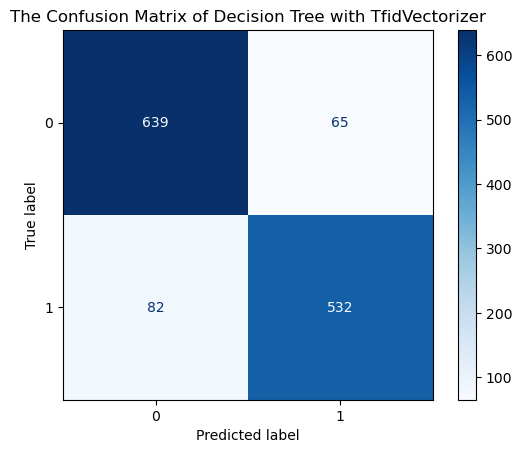

In [28]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe_tvec, param_grid=pipe_tvec_params, model_name="Decision Tree", transformer_name="TfidVectorizer")

## Random Forest

### Random Forest with CountVectorizer

In [29]:
# Instantiate the pipeline with Random Forest and countvectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("rf", RandomForestClassifier())
])

In [30]:
# Get pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

In [31]:
# Set pipeline params by cvec
pipe_params = {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "rf__max_depth": [None, 1, 2, 3, 4],
    "rf__n_estimators": [100]
}

==================== Summary of Random Forest Model with CountVectorizer Transformer Evaluation ===================
======== The Best Params =========
{'cvec__max_df': 0.9, 'cvec__max_features': 20000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'cvec__tokenizer': None, 'rf__max_depth': None, 'rf__n_estimators': 100}

========= The Best Score =========
0.89422746403367

========== Train Score ===========
0.9979757085020243

=========== Test Score ===========
0.8960546282245827


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.8960546282245827
Precision  --------- 0.8981636060100167
Sensitivity  ------- 0.8762214983713354
Specifity  --------- 0.9133522727272727


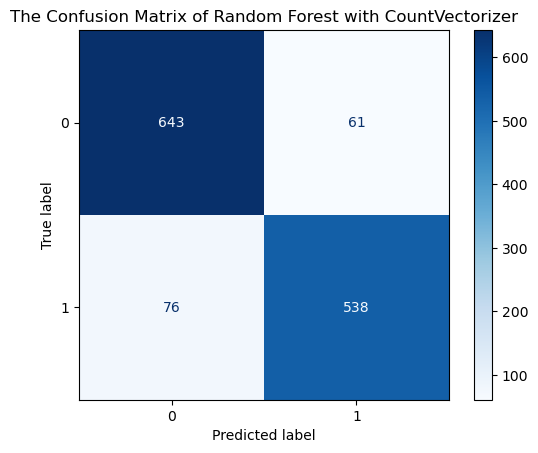

In [32]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="Random Forest", transformer_name="CountVectorizer")

### Feature Importance with CountVectorizer

Here I instantiated a CountVectorizer based on the best params that I got from GridSearch and then fit and transformed train data with that CountVectorizer. Also in the following, used defined function to plot top 20 features.

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


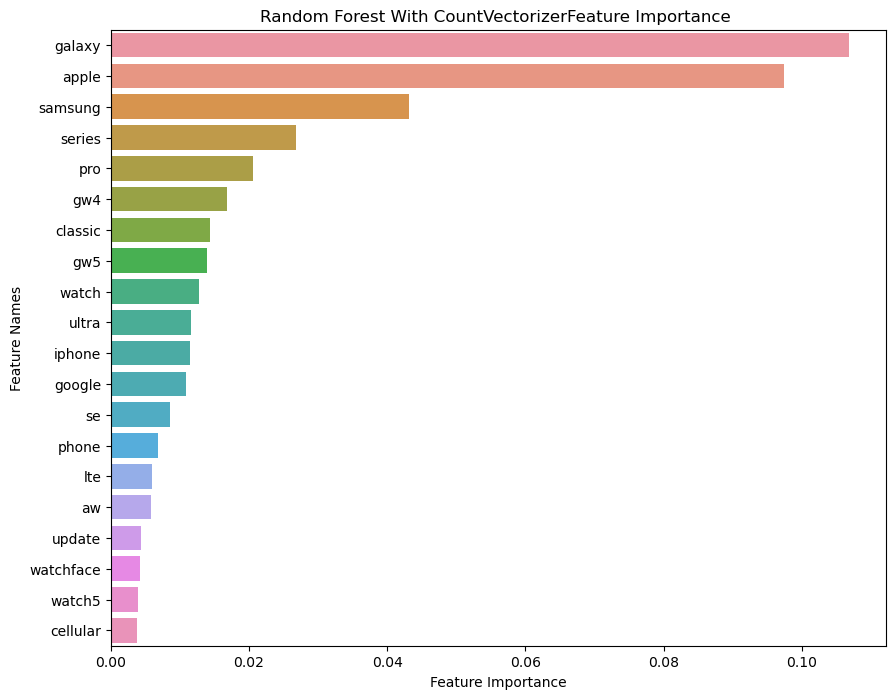

In [59]:
# instantiate TfidfVectorizer with best params 
cvec = CountVectorizer(max_df=0.9, max_features=20000, min_df=3, ngram_range=(1,1),
                       stop_words="english", tokenizer=None)
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

rf = RandomForestClassifier(max_depth=None, n_estimators=100)
rf.fit(X_train_cvec, y_train)

# make a train dataframe based on transformed data
X_train_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names())

# plot top 20 features
plot_feature_importance(rf.feature_importances_, X_train_df.columns,"Random Forest With CountVectorizer")

### Random Forest with TfidVectorizer

In [202]:
# redifine training and testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [203]:
# describe pipeline with multinomial Naïve Bayes algorithm with tfidvectorizer transformer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [204]:
# get to know pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 '

In [205]:
# set pipeline params by tvec
pipe_tvec_params = {
    'tvec__tokenizer': [None, stem_words],
    'tvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'rf__max_depth': [None, 1, 2, 3, 4],
    'rf__n_estimators': [100]
}

In [206]:
# Grid search over with pipeline estimator
gs_tvec = GridSearchCV(pipe_tvec, param_grid=pipe_tvec_params, cv=5, n_jobs=5)

# fit the model to traning data
gs_tvec.fit(X_train, y_train)

# get to know wich params were best ones
print(f'The best params  ---------- {gs_tvec.best_params_}')

# get to know the best score
print(f'The best score  ----------- {gs_tvec.best_score_}')

The best params  ---------- {'rf__max_depth': None, 'rf__n_estimators': 100, 'tvec__max_df': 0.95, 'tvec__max_features': 20000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None, 'tvec__tokenizer': None}
The best score  ----------- 0.8855180856983862


In [207]:
# train data score
gs_tvec.score(X_train, y_train)

0.9989986648865153

In [208]:
# test data score
gs_tvec.score(X_test, y_test)

0.8888888888888888

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


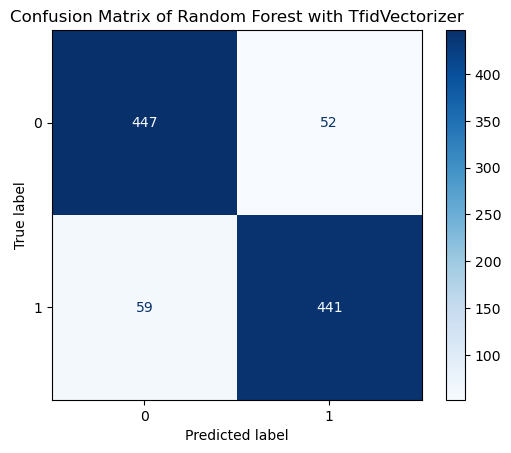

In [209]:
# Get predictions
preds = gs_tvec.predict(X_test)

#confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# confusion matrix
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix of Random Forest with TfidVectorizer');

### Evaluation for Model with Random Forest Algorithm and TfidVectorizer Transformer

In [210]:
print(f'The accuracy score with  ----- {accuracy_score(y_test, preds)}')
print(f'The precision score   -------- {precision_score(y_test, preds)}')
print(f'The sensitivity score  ------- {recall_score(y_test, preds)}')
print(f'The specifity score  --------- {tn/(tn + fp)}')

The accuracy score with  ----- 0.8888888888888888
The precision score   -------- 0.8945233265720081
The sensitivity score  ------- 0.882
The specifity score  --------- 0.8957915831663327


### Feature Importance with Random Forest Algorithm and TfidVectorizer Transformer

Here I instantiated a TfidfVectorizer based on the best params that I got from GridSearch and then fit and transformed train data with that TfidfVectorizer. Also in the following used defined function to plot top 20 features.

In [ ]:
'tvec__max_df': 0.95, 'tvec__max_features': 20000, 'tvec__min_df': 3,
'tvec__ngram_range': (1, 1), 'tvec__stop_words': None,

In [215]:
# instantiate TfidfVectorizer with best params 
tvec = TfidfVectorizer(max_df=0.95, max_features=20000, min_df=3, ngram_range=(1,1),
                       stop_words=None, tokenizer=None)
# make a train dataframe based on transformed data
X_train_tvec_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [216]:
# get to know feature importances
gs_tvec.best_estimator_._final_estimator.feature_importances_

array([3.29423938e-05, 4.37726929e-05, 2.86362601e-05, ...,
       1.05939094e-05, 0.00000000e+00, 1.21914693e-04])

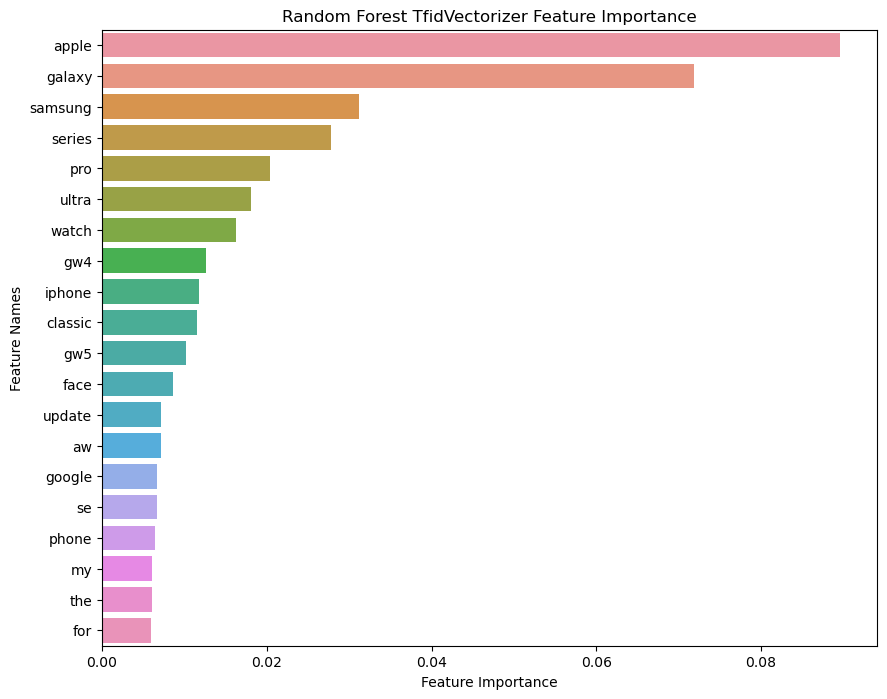

In [217]:
# plot top 20 features
plot_feature_importance(gs_tvec.best_estimator_._final_estimator.feature_importances_,
                        X_train_tvec_df.columns,'Random Forest TfidVectorizer')